In [ ]:
# This is the first in a series of experiments with object-detection based models.
# In particular, these offer a few interesting directions and challenges.
# 1. Should malleus and oval detection be combined, or separate?
# 2. Should presence (vs position) of malleus or oval be detected by same model, or separate?
# 3. How to best handle inconsistencies with bounding box angle, aspect?
#    E.g, whether it was rotated CW or CCW to reach target, whether it was skewed landscape or portrait.
#
# 4. How best to handle resizing BB coordinates based on image crop, scale?
# 5. What loss to use? Detect center-points or extents?


# Based on all this, the first goal is simply to achieve basic center-coord regression, using MSE on the euclidean distance.
# Setup AWS CLI
!pip install awscli
!aws configure

# Setup AWS
Download required datasets from the S3 service.
This includes the following:

1. Partitioned Annotations (Y) : the S3 storage bucket contains separate folders, each with a set of annotations.

2. Images (X): raw images that serve as inputs to the model.

In [ ]:
# Download data from S3.
# This will stay on this machine only as long as the session is active, and will be deleted afterwards.
!aws s3 cp --recursive s3://uoftremmiedata/annotations_v5_object_detection ./annotations-partitioned
!aws s3 cp --recursive s3://uoftremmiedata/diagnosis_images ./images

# Data Unpacking
Our downloaded data must be transformed into an easier to use structure. This does not perform any image pre-processing, just directory work to play nicely with our model's data-loading tools.

In [ ]:
import glob
import json
import shutil
import os

# Un-partition the annotated images.
# Also, name the files using the same structure as images, for easier lookup.
!rm -rf annotations
!mkdir annotations

for path in glob.glob("annotations-partitioned/*/*"):
  with open(path, "r") as annotation_file:
    annotation_json = json.load(annotation_file)

    # Extract the image name that this annotation was made for.
    # This will be an S3 URL, of the form s3:/path/to/CLASS/NAME.jpeg
    image_resource = annotation_json["task"]["data"]["image"]
    path_components = image_resource.split("/")
    image_class, image_filename = path_components[-2:]

    # Remove the extension from the image name, for our annotation file.
    image_name = "".join(image_filename.split(".")[:-1])

    # Mirror the data directory structure.
    if image_name:
      output_dir = os.path.join("annotations", image_class)
      if not os.path.exists(output_dir):
        os.makedirs(output_dir)

      # Instead of just copying, also pretty-print the annotation for ease of use.
      with open(os.path.join(output_dir, f"{image_name}.json"), "w") as output_file:
        json.dump(annotation_json, output_file, indent=2)

# Malleus Handle Center-Coordinate Regression

Our dataset consists of circular images surrounding by a large rectangular border. We of course want to exclude this border.

However, this creates quite a bit of coordinate transformation, which these utility classes help with.

In [ ]:
import json
import math
import os
import glob
import typing
import dataclasses
from torchvision.io import read_image
from PIL import Image, ImageDraw

class ImageCoordinates:
  """
  Represents the coordinate-space in a particular image,
  based on its dimensions and central circular viewport.
  Allows us to easily translate between different coordinate spaces.
  """

  def __init__(self, width, height, viewport_radius):
    self.width = width
    self.height = height

    self.viewport_radius = viewport_radius
    self.size = (2 * viewport_radius) / math.sqrt(2)

    self.padding_x = (width - self.size) / 2
    self.padding_y = (height - self.size) / 2

  def relative_to_absolute(self, x, y):
    return (x / 100) * self.width, (y / 100) * self.height

  def absolute_to_viewport(self, x, y):
    return x / self.size, y / self.size

  def absolute_to_viewport_point(self, x, y):
    return self.absolute_to_viewport(x - self.padding_x, y - self.padding_y)


class Position:
  """
  A position of some object within an image-space.
  """
  image_coords: ImageCoordinates
  x: float
  y: float
  rotation_degs: float

  def __init__(self, image_coords, x, y, rotation_degs):
    self.image_coords = image_coords
    self.x, self.y = image_coords.absolute_to_viewport_point(
      *image_coords.relative_to_absolute(x, y)
    )
    self.rotation_degs = rotation_degs
    self.rotation_rads = math.radians(rotation_degs)

class RectanglePosition(Position):
  """
  A rectangular object within an image-space.
  """

  width: float
  height: float

  def __init__(self, image_coords, x, y, rotation_degs, width, height):
    super().__init__(image_coords, x, y, rotation_degs)
    self.width, self.height = image_coords.absolute_to_viewport(
      *image_coords.relative_to_absolute(width, height)
    )

    # Calculate the centroid position.
    # To do this, we first calculate the local centroid (ignoring rotation, position)
    # Then scale to a global one.
    # Note: this math is based on the assumption that the viewport has equal width, height.
    # Otherwise, we must explicitly convert the coordinates back into absolute (vs relative) first.
    local_centroid_x, local_centroid_y = self.width/2, self.height/2
    self.centroid_x = self.x + (local_centroid_x * math.cos(self.rotation_rads)) - (local_centroid_y * math.sin(self.rotation_rads))
    self.centroid_y = self.y + (local_centroid_x * math.sin(self.rotation_rads)) + (local_centroid_y * math.cos(self.rotation_rads))

  def get_segmentation_mask(self):
    # Create segmentation mask
    segmentation_mask = Image.new("RGB", (1061, 1061))

    half_width = self.width / 2
    half_height = self.height / 2

    c = math.cos(self.rotation_rads);()
    s = math.sin(self.rotation_rads);

    r1x = -half_width * c - half_height * s;
    r1y = -half_width * s + half_height * c;
    r2x =  half_width * c - half_height * s;
    r2y =  half_width * s + half_height * c;

    coordinates = [
      (image_coords.size * (self.x + r1x), image_coords.size*(self.y + r1y)),
      (image_coords.size * (self.x + r2x), image_coords.size*(self.y + r2y)),
      (image_coords.size * (self.x - r1x), image_coords.size*(self.y - r1y)),
      (image_coords.size * (self.x - r2x), image_coords.size*(self.y - r2y))
    ]

    draw = ImageDraw.Draw(segmentation_mask)
    draw.polygon(coordinates, fill=(255, 255, 255))
    return segmentation_mask

class EllipsePosition(Position):
  """
  An elliptical object within an image space.
  """

  radius_x: float
  radius_y: float

  def __init__(self, image_coords, x, y, rotation_degs, radius_x, radius_y):
    super().__init__(image_coords, x, y, rotation_degs)
    self.radius_x, self.radius_y = image_coords.absolute_to_viewport (
      *image_coords.relative_to_absolute(radius_x, radius_y)
    )

    local_centroid_x, local_centroid_y = self.radius_x/2, self.radius_y/2
    self.centroid_x = self.x
    self.centroid_y = self.y

# For now, we assume that all images have the same size and structure.
image_coords = ImageCoordinates(
  width=2560,
  height=1920,
  viewport_radius=750
)

class Datapoint:
  annotation_path: str
  image_path: str
  image_class: str
  image_name: str

  malleus: typing.Optional[RectanglePosition]
  eardrum: typing.Optional[EllipsePosition]

  def __init__(self, annotation_path):
    self.annotation_path = annotation_path

    path_components = self.annotation_path.split("/")
    self.image_class = path_components[-2]
    self.image_name = path_components[-1].split(".json")[0]

    with open(self.annotation_path, "r") as f:
      self.annotation_json = json.load(f)

    self.image_path = f"images/{self.image_class}/{self.image_name}.jpeg"

    self.malleus = None
    self.eardrum = None

    for result in self.annotation_json["result"]:
      if result["type"] == "rectanglelabels":
        self.malleus = RectanglePosition(
          image_coords,
          x = result["value"]["x"],
          y = result["value"]["y"],
          rotation_degs = result["value"]["rotation"],
          height = result["value"]["height"],
          width = result["value"]["width"],
        )
      elif result["type"] == "ellipselabels":
        self.eardrum = EllipsePosition(
          image_coords,
          x = result["value"]["x"],
          y = result["value"]["y"],
          rotation_degs = result["value"]["rotation"],
          radius_x = result["value"]["radiusX"],
          radius_y = result["value"]["radiusY"],
        )

  def get_image_tensor(self):
    return read_image(self.image_path)

# Load all annotations and image-paths into datastructure.
datapoints: typing.List[Datapoint] = []

for annotation_path in glob.glob("annotations/*/*", recursive=True):
  datapoints += [Datapoint(annotation_path)]

# Filter down to only images that contain both a malleus and ellipse annotation.
datapoints = [d for d in datapoints if (d.malleus is not None) and (d.eardrum is not None)]

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
from matplotlib import pyplot as plt
import typing

def display_image_coord(image_tensor, malleus_centroid_tensor, eardrum_centroid_tensor):
  plt.imshow(image_tensor.permute(1, 2, 0))
  plt.plot(
    malleus_centroid_tensor[0] * image_coords.size,
    malleus_centroid_tensor[1] * image_coords.size,
    "x"
  )

  plt.plot(
    eardrum_centroid_tensor[0] * image_coords.size,
    eardrum_centroid_tensor[1] * image_coords.size,
    "o"
  )

class MalleusCentroidDataset(Dataset):
  datapoints: typing.List[Datapoint]

  def __init__(self, datapoints):
    self.datapoints = datapoints

  def __len__(self):
    return len(self.datapoints)

  def __getitem__(self, idx):
    # Get the image tensor, and center-crop it.
    image_tensor = read_image(self.datapoints[idx].image_path)
    image_tensor = image_tensor[
      :,
      int(image_coords.padding_y) : int(image_coords.padding_y + image_coords.size),
      int(image_coords.padding_x) : int(image_coords.padding_x + image_coords.size)
    ]

    malleus = typing.cast(RectanglePosition, self.datapoints[idx].malleus)
    eardrum = typing.cast(RectanglePosition, self.datapoints[idx].eardrum)

    malleus_centroid_tensor = torch.tensor([
      malleus.centroid_x,
      malleus.centroid_y
    ])

    eardrum_centroid_tensor = torch.tensor([
      eardrum.centroid_x,
      eardrum.centroid_y
    ])

    return image_tensor, malleus_centroid_tensor, eardrum_centroid_tensor, torch.tensor([malleus.rotation_rads])

  def display(self, idx):
    image_tensor, malleus_centroid_tensor, eardrum_centroid_tensor, _ = self[idx]
    display_image_coord(image_tensor, malleus_centroid_tensor, eardrum_centroid_tensor)

# Modelling
Now that all of that data loading and transformation is complete, we can *finally* get to modelling.

In [ ]:
!pip install pytorch-lightning
!pip install torchsummary
!pip install wandb
!wandb login

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 KB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 44.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 KB 21.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.1 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=20b3f5336656bbd5967a946a1855543973b2c9644d60f60f304736f653ea43af
  Stored in directory: /

In [ ]:
from torch.utils.data import random_split
torch.manual_seed(42)

ds = MalleusCentroidDataset(datapoints)

split_train = int(0.6 * len(ds))
split_val = int(0.3 * len(ds))
split_test = len(ds) - split_train - split_val

ds_train, ds_val, ds_test = random_split(ds, [split_train, split_val, split_test])


In [ ]:
import pytorch_lightning as pl
from torch import nn
from torchsummary import summary
from torchvision.transforms.functional import resize
from pytorch_lightning.loggers import WandbLogger
import wandb
import torchvision
import torchvision.transforms.functional
from pytorch_lightning.callbacks import LearningRateMonitor
import torch

import torchvision.models
class ImagenetMalleusCentroidRegressor(pl.LightningModule):
  def __init__(self, config):
    super().__init__()

    self.config = config

    # Apply transfer learning through an existing image classifier.
    if config["backbone"] == "resnet50":
      pretrained_model = torchvision.models.resnet50(torchvision.models.ResNet50_Weights.DEFAULT)
      num_extractor_features = pretrained_model.fc.in_features
      self.preprocess = torchvision.models.ResNet50_Weights.DEFAULT.transforms()

      self.feature_extractor = nn.Sequential(
        *list(pretrained_model.children())[:-1]
      )

    elif config["backbone"] == "vgg19":
      pretrained_model = torchvision.models.vgg19(torchvision.models.VGG19_Weights.DEFAULT)
      num_extractor_features = 1000
      self.preprocess = torchvision.models.VGG19_Weights.DEFAULT.transforms()
      self.feature_extractor = nn.Sequential(
          *list(pretrained_model.classifier[:-1])
      )

    self.feature_extractor.eval()

    # Regress to an X/Y coordinate pair.
    # Or rather, separate pairs for malleus/eardrum.
    if "rfb" in self.config and self.config["rfb"]:
      self.regressor = nn.Sequential(
        nn.Linear(num_extractor_features, 500),
        nn.ReLU(),
        nn.Linear(500, 100),
        nn.ReLU(),
        nn.Linear(100, 50),
        nn.ReLU(),
        nn.Linear(50, 2 + 2)
      )
    else:
      self.regressor = nn.Sequential(
        nn.Linear(num_extractor_features, 100),
        nn.ReLU(),
        nn.Linear(100, 2 + 2)
      )

    self.loss = nn.L1Loss()
    self.transform = torchvision.transforms.Compose([
        torchvision.transforms.ColorJitter(),
        torchvision.transforms.RandomAutocontrast(1),
    ])

    self.optimizer = torch.optim.SGD(self.parameters(), config["lr"], config["momentum"], config["weight_decay"])
    self.save_hyperparameters()

  def forward(self, x):
    # x = resize(x, [224]).float() / 255.0
    if self.current_epoch > self.config["finetune_epoch"]:
      self.feature_extractor.train()

    x = self.preprocess(x)

    features = self.feature_extractor(x).flatten(1)
    x = self.regressor(features)

    if "sigmoid_clamp" in self.config and self.config["sigmoid_clamp"]:
      # We apply a sigmoid clamp, but use tanh because it is known to have
      # better gradient performance.
      x = torch.tanh(x) + 0.5

    return x

  def loss_fn(self, output, target):
    return self.loss(output, target)

  def configure_optimizers(self):
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, "min")

    return {
      "optimizer": self.optimizer,
      "lr_scheduler": scheduler,
      "monitor": "loss/val"
    }

  def training_step(self, batch, batch_idx):
    x, y_malleus, y_eardrum, y_malleus_rotation = batch

    if "random_flip" in self.config and self.config["random_flip"]:
      for i in range(len(x)):
        p = torch.randint(0, 4, (1, 1))[0][0]
        if p == 0:
          pass
        elif p == 1:
          x[i] = torchvision.transforms.functional.hflip(x[i])
          y_malleus[i] = torch.tensor([-1, 1]).cuda() * y_malleus[i] + torch.tensor([1, 0]).cuda()
          y_eardrum[i] = torch.tensor([-1, 1]).cuda() * y_eardrum[i] + torch.tensor([1, 0]).cuda()
        elif p == 2:
          x[i] = torchvision.transforms.functional.vflip(x[i])
          y_malleus[i] = torch.tensor([1, -1]).cuda() * y_malleus[i] + torch.tensor([0, 1]).cuda()
          y_eardrum[i] = torch.tensor([1, -1]).cuda() * y_eardrum[i] + torch.tensor([0, 1]).cuda()
        elif p == 3:
          x[i] = torchvision.transforms.functional.hflip(torchvision.transforms.functional.vflip(x[i]))
          y_malleus[i] = torch.tensor([-1, -1]).cuda() * y_malleus[i] + torch.tensor([1, 1]).cuda()
          y_eardrum[i] = torch.tensor([-1, -1]).cuda() * y_eardrum[i] + torch.tensor([1, 1]).cuda()



    out = self(self.transform(x))
    loss = self.loss_fn(out, torch.concat([y_malleus, y_eardrum], dim=1))

    self.log("loss/train", loss)
    return loss

  def validation_step(self, batch, batch_idx):
    x, y_malleus, y_eardrum, y_malleus_rotation = batch
    out = self(x)
    loss = self.loss_fn(out, torch.concat([y_malleus, y_eardrum], dim=1))

    self.log("loss/val", loss)
    return loss

  def train_dataloader(self):
    return DataLoader(ds_train, batch_size=self.config["batch_size"], shuffle=True, num_workers=4)

  def val_dataloader(self):
    return DataLoader(ds_val, batch_size=16, shuffle=False, num_workers=4)

if False:
  !WANDB_NOTEBOOK_NAME="Object Detection - Malleus Centroids"
  config = {
    "lr": 1e-4,
    "momentum": 0.2,
    "weight_decay": 1e-3,
    "batch_size": 8,
    "backbone": "resnet50",
    "finetune_epoch": 0,
    "epochs": 300,
    "sigmoid_clamp": False,
    "random_flip": True,
    "rfb": True
  }

  run = wandb.init(project="combined-centroid-detection-imagenet", settings=wandb.Settings(code_dir="."), config=config)
  model = ImagenetMalleusCentroidRegressor(
    config=config
  )
  wandb_logger = WandbLogger(log_model=True)
  trainer = pl.Trainer(max_epochs=config["epochs"], accelerator="gpu", logger=wandb_logger, log_every_n_steps=5, callbacks=[
    LearningRateMonitor(logging_interval="step")
  ])
  trainer.fit(model)
  torch.save({
    "model_state_dict": model.state_dict(),
    "config": config
  }, "model.ckpt")
  run.save("model.ckpt")


In [ ]:
models_to_use = [
  ("remmie-uoft/combined-centroid-detection-imagenet/394f3a17", "rich-smoke-24"),
  # ("remmie-uoft/combined-centroid-detection-imagenet/2m3hhqj4", "summer-snowball-25"),
  # ("remmie-uoft/combined-centroid-detection-imagenet/32y7a38k", "lemon-darkness-42"),
  # ("remmie-uoft/combined-centroid-detection-imagenet/2j0b76k5", "toasty-disco-27"),
  # ("remmie-uoft/combined-centroid-detection-imagenet/2cyrxqld", "fresh-frost-45")
]

models = []

for (model_path, name) in models_to_use:
  run = wandb.Api().run(model_path)
  run.file("model.ckpt").download(replace=True)
  checkpoint = torch.load("model.ckpt", map_location=torch.device("cpu"))
  model = ImagenetMalleusCentroidRegressor(config=run.config)
  model.load_state_dict(checkpoint["model_state_dict"])
  models.append((model, name))

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Average Distances
rich-smoke-24: malleus: 0.15664401650428772, eardrum: 0.0698847621679306


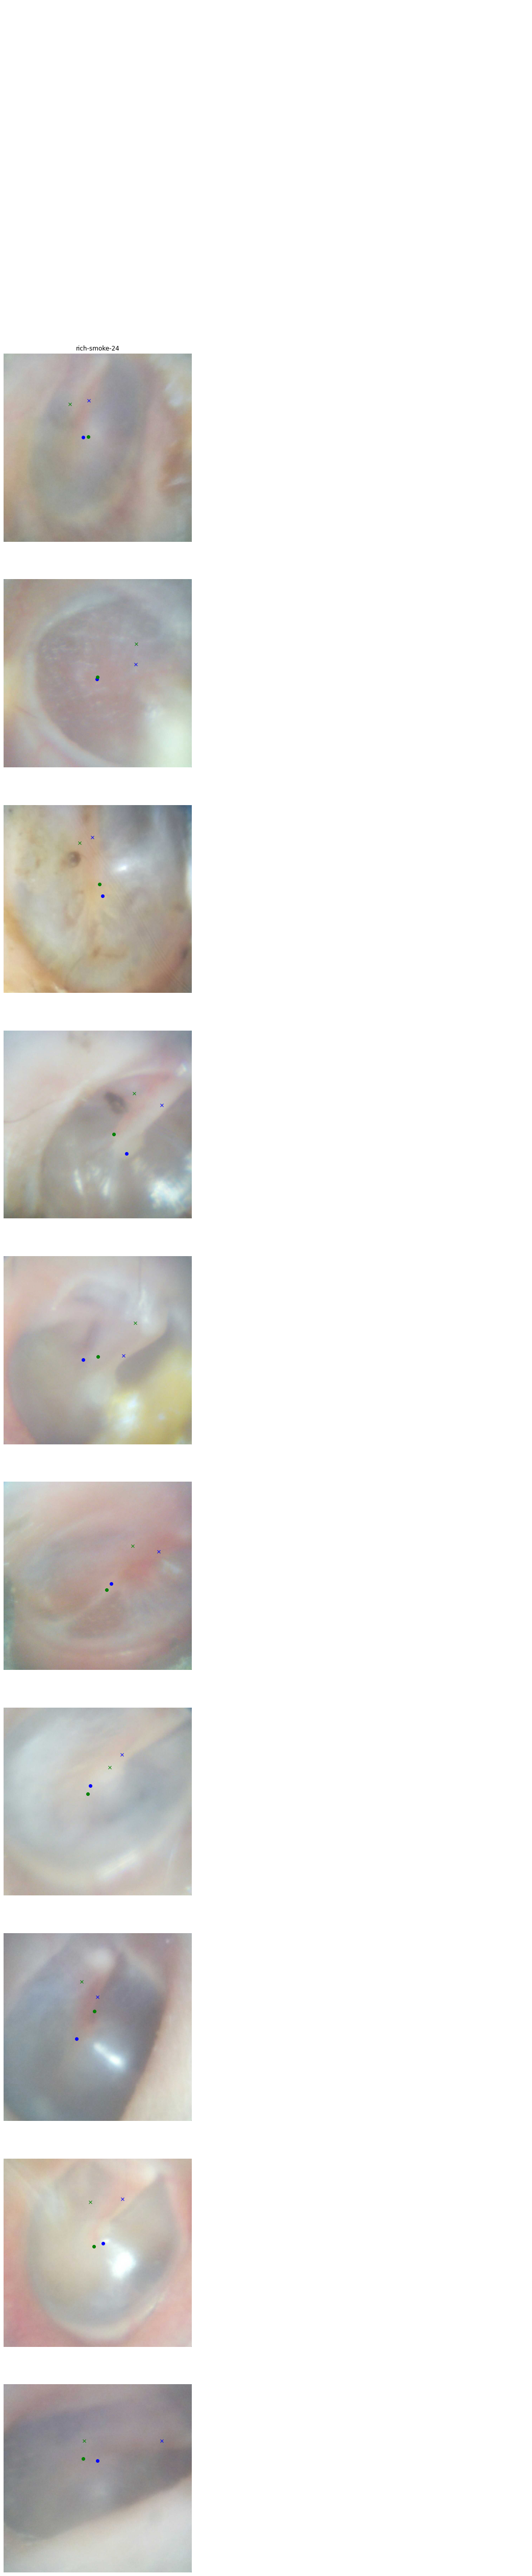

In [ ]:
from matplotlib.gridspec import GridSpec
from collections import defaultdict

images_to_show = list(range(10))

fig = plt.figure(figsize=(16, 80))
gs = GridSpec(len(images_to_show), len(models), figure=fig)

malleus_distances = defaultdict(list)
eardrum_distances = defaultdict(list)

for i_image, image in enumerate(images_to_show):
  for i_model, (model, name) in enumerate(models):
    ax = fig.add_subplot(gs[i_image, i_model])
    x, y_malleus, y_eardrum, _ = ds_test[image]

    prediction = model(x.unsqueeze(0)).detach()[0]
    pred_malleus, pred_eardrum = torch.split(prediction, 2)

    ax.imshow(x.permute(1, 2, 0))

    ax.plot(y_malleus[0] * image_coords.size, y_malleus[1] * image_coords.size, "bx", label="Ground Truth Malleus")
    ax.plot(y_eardrum[0] * image_coords.size, y_eardrum[1] * image_coords.size, "bo", label="Ground Truth Eardrum")
    ax.plot(pred_malleus[0] * image_coords.size, pred_malleus[1] * image_coords.size, "gx", label="Predicted Malleus")
    ax.plot(pred_eardrum[0] * image_coords.size, pred_eardrum[1] * image_coords.size, "go", label="Predicted Eardrum")

    malleus_distances[name] += [((y_malleus[0] - pred_malleus[0])**2 + (y_malleus[1] - pred_malleus[1])**2)**0.5]
    eardrum_distances[name] += [((y_eardrum[0] - pred_eardrum[0])**2 + (y_eardrum[1] - pred_eardrum[1])**2)**0.5]

    if i_image == 0:
      ax.set_title(name)

    if i_model == 0:
      ax.set_xlabel(i_image)
    ax.axis("off")
    handles, labels = ax.get_legend_handles_labels()

print("Average Distances")
for model, name in models:
  print(f"{name}: malleus: {sum(malleus_distances[name]) / len(malleus_distances[name])}, eardrum: {sum(eardrum_distances[name]) / len(eardrum_distances[name])}")

fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.25, 1))